# Audio Classification Using Spectrograms and Deep Learning
## Overview
Processing raw audio as spectrograms is a crucial step in most audio-based applications. Spectrograms provide a visual representation of an audio signal’s frequency content over time, making them highly effective for deep learning models.

This project demonstrates how to preprocess audio waveforms into spectrograms using the STFTSpectrogram layer in Keras and utilize them for audio classification. We implement two different approaches—one treating spectrograms as 1D signals and another treating them as images (2D signals) with a pretrained vision model.

## Project Workflow
1. **Load the ESC-10 Dataset** – A subset of the Environmental Sound Classification dataset containing 10 classes of common environmental sounds.
2. **Preprocess Audio** – Convert raw waveforms into spectrograms using Short-Time Fourier Transform (STFT).
3. **Build Two Deep Learning Models**:
- A model that processes spectrograms as 1D sequences and classifies audio using an LSTM-based architecture.
- A model that treats spectrograms as 2D images, leveraging a pretrained convolutional neural network (CNN).
4. **Train and Evaluate** – Compare the performance of both models on the ESC-10 dataset.

This project serves as a practical guide to leveraging spectrogram transformations for deep learning-based audio classification

## Setup
### Importing Libraries

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io.wavfile
from keras import layers
from scipy.signal import resample

keras.utils.set_random_seed(41)

### Defining Variables

In [4]:
BASE_DATA_DIR = "./datasets/esc-50_extracted/ESC-50-master/"
BATCH_SIZE = 16
NUM_CLASSES = 10
EPOCHS = 200
SAMPLE_RATE = 16000

## Dataset Preparation

### 1. Download and Extract the ESC-10 Dataset

The dataset used in this project is the ESC-10, a subset of the Environmental Sound Classification (ESC-50) dataset. It consists of five-second .wav files representing various environmental sounds.

To download and extract the dataset, we use the keras.utils.get_file() function:

In [5]:
keras.utils.get_file(
    "esc-50.zip",
    "https://github.com/karoldvl/ESC-50/archive/master.zip",
    cache_dir="./",
    cache_subdir="datasets",
    extract=True,
)

645382144/Unknown 47s 0us/step

'./datasets/esc-50_extracted'

### 2. Load and Filter the Dataset

In [6]:
pd_data = pd.read_csv(os.path.join(BASE_DATA_DIR, "meta", "esc50.csv"))
# filter ESC-50 to ESC-10 and reassign the targets
pd_data = pd_data[pd_data["esc10"]]
targets = sorted(pd_data["target"].unique().tolist())
assert len(targets) == NUM_CLASSES
old_target_to_new_target = {old: new for new, old in enumerate(targets)}
pd_data["target"] = pd_data["target"].map(lambda t: old_target_to_new_target[t])
pd_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,9,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,4,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,8,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,1,rooster,True,233160,A
1888,5-234879-A-1.wav,5,1,rooster,True,234879,A
1889,5-234879-B-1.wav,5,1,rooster,True,234879,B
1894,5-235671-A-38.wav,5,7,clock_tick,True,235671,A


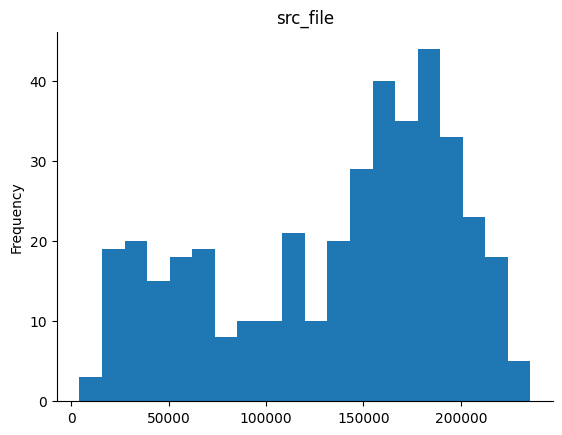

In [10]:
from matplotlib import pyplot as plt
pd_data['src_file'].plot(kind='hist', bins=20, title='src_file')
plt.gca().spines[['top', 'right',]].set_visible(False)

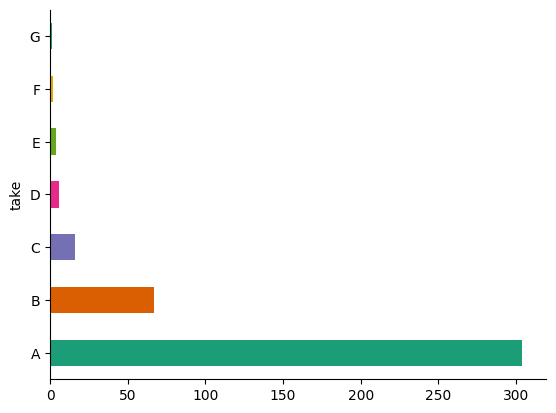

In [12]:
import seaborn as sns
pd_data.groupby('take').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

###3. Load and Preprocess WAV Filesction

In [7]:
def read_wav_file(path, target_sr=SAMPLE_RATE):
    sr, wav = scipy.io.wavfile.read(os.path.join(BASE_DATA_DIR, "audio", path))
    wav = wav.astype(np.float32) / 32768.0  # normalize to [-1, 1]
    num_samples = int(len(wav) * target_sr / sr)  # resample to 16 kHz
    wav = resample(wav, num_samples)
    return wav[:, None]  # Add a channel dimension (of size 1)

- This function ensures all audio samples are uniformly preprocessed before converting them into spectrograms.

## Generating and Visualizing Spectrograms
Next step is to convert the waveforms into spectrograms.

**Spectrograms **are time-frequency representations of audio signals, making them ideal for audio classification tasks. We will use STFT (Short-Time Fourier Transform) to generate these spectrograms.

### 1. Compute and Plot a Single-Channel Spectrogram
This function computes a spectrogram from an audio waveform using STFTSpectrogram and visualizes it

In [8]:
def plot_single_spectrogram(sample_wav_data):
    """
    Compute and visualize a single-channel spectrogram using STFT.

    Parameters:
    sample_wav_data (numpy array): Preprocessed audio waveform.

    Returns:
    None (Displays the spectrogram plot)
    """
    spectrogram = layers.STFTSpectrogram(
        mode="log",
        frame_length=SAMPLE_RATE * 20 // 1000,  # 20ms frame length
        frame_step=SAMPLE_RATE * 5 // 1000,  # 5ms frame step
        fft_length=1024,  # Number of FFT bins
        trainable=False,  # Keep transformation fixed
    )(sample_wav_data[None, ...])[0, ...]

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.T, origin="lower", aspect="auto", cmap="magma")
    plt.colorbar(label="Log Magnitude")
    plt.title("Single-Channel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()


### 2. Compute and Plot a Multi-Bandwidth Spectrogram

nstead of using a single spectrogram, we can compute multiple spectrograms at different bandwidths and align them as different color channels to enhance feature extraction.

In [9]:
def plot_multi_bandwidth_spectrogram(sample_wav_data):
    """
    Compute and visualize a multi-bandwidth spectrogram with three different frame lengths.

    Parameters:
    sample_wav_data (numpy array): Preprocessed audio waveform.

    Returns:
    None (Displays the multi-bandwidth spectrogram plot)
    """
    spectrograms = np.concatenate(
        [
            layers.STFTSpectrogram(
                mode="log",
                frame_length=SAMPLE_RATE * x // 1000,
                frame_step=SAMPLE_RATE * 5 // 1000,
                fft_length=1024,
                padding="same",
                expand_dims=True,  # Ensure compatibility with image models
            )(sample_wav_data[None, ...])[0, ...]
            for x in [5, 10, 20]  # Different frame lengths (5ms, 10ms, 20ms)
        ],
        axis=-1,
    ).transpose([1, 0, 2])  # Transpose to match image format

    # Normalize each color channel for better visualization
    mn = spectrograms.min(axis=(0, 1), keepdims=True)
    mx = spectrograms.max(axis=(0, 1), keepdims=True)
    spectrograms = (spectrograms - mn) / (mx - mn)

    # Plot the multi-bandwidth spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrograms, origin="lower", aspect="auto")
    plt.title("Multi-Bandwidth Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()


### 3. Demonstrate with a Sample Audio File

To verify our spectrogram generation, we select a sample from the dataset and visualize both its waveform and spectrogram.

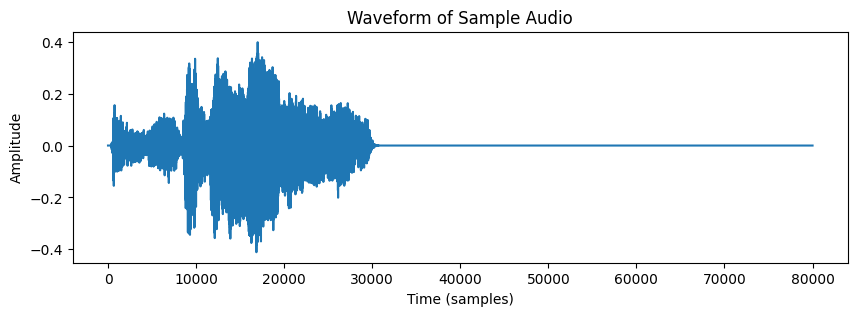

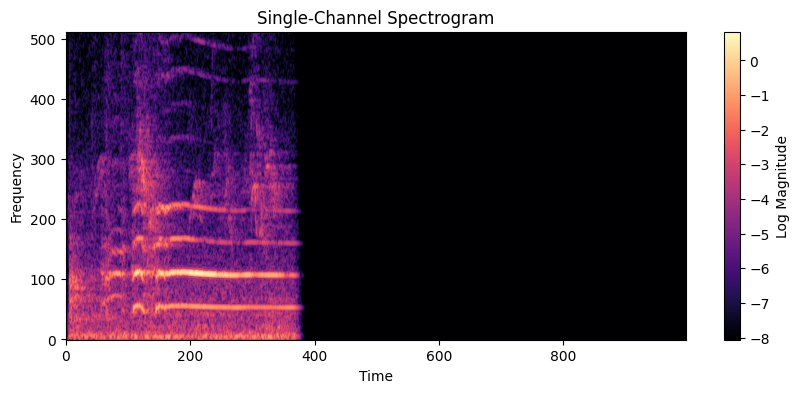

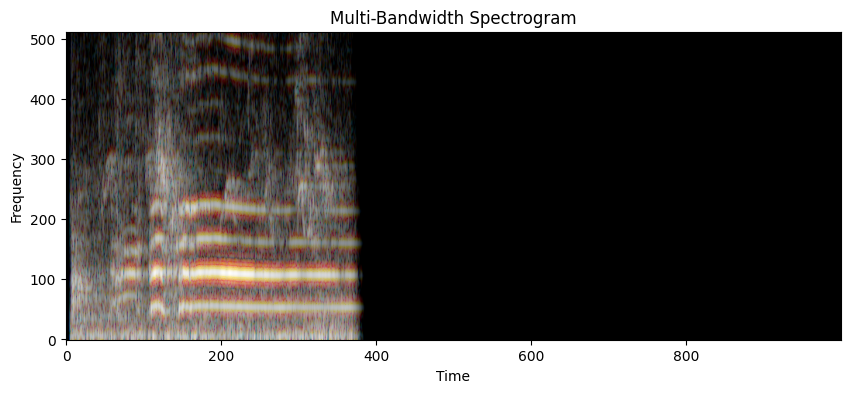

In [10]:
# Select a sample audio file
sample_wav_data = read_wav_file(pd_data["filename"].tolist()[52])

# Plot the raw waveform
plt.figure(figsize=(10, 3))
plt.plot(sample_wav_data[:, 0])
plt.title("Waveform of Sample Audio")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

# Generate and plot spectrograms
plot_single_spectrogram(sample_wav_data)
plot_multi_bandwidth_spectrogram(sample_wav_data)


## Training and Experimenting with STFT Spectrograms
### 1. Constructing the TensorFlow Dataset
To structure our dataset for model training, we define a function that extracts waveform data from audio files based on predefined folds.

In [11]:
def read_dataset(df, folds):
    msk = df["fold"].isin(folds)
    filenames = df["filename"][msk]
    targets = df["target"][msk].values
    waves = np.array([read_wav_file(fil) for fil in filenames], dtype=np.float32)
    return waves, targets

In [12]:
train_x, train_y = read_dataset(pd_data, [1, 2, 3])
valid_x, valid_y = read_dataset(pd_data, [4])
test_x, test_y = read_dataset(pd_data, [5])

### 2. Training Models with STFT Spectrograms
In this section, we explore different configurations of the STFTSpectrogram layer to preprocess audio waveforms before feeding them into neural networks.

#### Model 1: 1D ConvNet with a Non-Trainable STFTSpectrogram Layer
- Converts raw waveforms into log STFT spectrograms.
- Uses Conv1D layers to process the 1D spectral features.
- Employs global max pooling to extract fixed-size feature representations.
- Final classification is done using fully connected layers.

##### Model Architecture

In [1]:
model1d = keras.Sequential(
    [
        layers.InputLayer((None, 1)),
        layers.STFTSpectrogram(
            mode="log",
            frame_length=SAMPLE_RATE * 40 // 1000,
            frame_step=SAMPLE_RATE * 15 // 1000,
            trainable=False,
        ),
        layers.Conv1D(64, 64, activation="relu"),
        layers.Conv1D(128, 16, activation="relu"),
        layers.LayerNormalization(),
        layers.MaxPooling1D(4),
        layers.Conv1D(128, 8, activation="relu"),
        layers.Conv1D(256, 8, activation="relu"),
        layers.Conv1D(512, 4, activation="relu"),
        layers.LayerNormalization(),
        layers.Dropout(0.5),
        layers.GlobalMaxPooling1D(),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="model_1d_non_trainble_stft",
)
model1d.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model1d.summary()

NameError: name 'keras' is not defined

#### Model Compilation

In [22]:
model1d.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


#### Model Summary

The model consists of 4M+ parameters, with 656K non-trainable parameters from the STFT layer.
```csharp
Model: "model_1d_non_trainble_stft"
Total params: 4,008,522 (15.29 MB)
Trainable params: 3,351,882 (12.79 MB)
Non-trainable params: 656,640 (2.50 MB)
```
### 3. Training the Model and Restoring the Best Weights
To ensure the best possible performance, we train the model with an early stopping mechanism that restores the best weights based on validation loss.

In [24]:
history_model1d = model1d.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=EPOCHS,  # Stop training if no improvement
            restore_best_weights=True,
        )
    ],
)


Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1281 - loss: 3.1472 - val_accuracy: 0.1625 - val_loss: 2.3872
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1222 - loss: 2.6200 - val_accuracy: 0.1000 - val_loss: 2.3594
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1231 - loss: 2.5566 - val_accuracy: 0.1000 - val_loss: 2.3925
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1466 - loss: 2.4493 - val_accuracy: 0.1000 - val_loss: 2.3597
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1303 - loss: 2.4329 - val_accuracy: 0.1000 - val_loss: 2.3352
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1214 - loss: 2.3667 - val_accuracy: 0.1000 - val_loss: 2.3488
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1813 - loss: 2.2862 - val_accuracy: 0.1125 - val_loss: 2.3013
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2345 - loss: 2.2264 - val_accuracy: 0.1000 - v

## Create the 2D model
1. Create three spectrograms with multiple band-widths from the raw input.
2. Concatenate the three spectrograms to have three channels.
3. Load MobileNet and set the weights from the weights trained on ImageNet.
4. Apply global maximum pooling to have fixed set of features.
5. Add Dense layers to make the final predictions based on the features.

In [20]:
input = layers.Input((None, 1))
spectrograms = [
    layers.STFTSpectrogram(
        mode="log",
        frame_length=SAMPLE_RATE * frame_size // 1000,
        frame_step=SAMPLE_RATE * 15 // 1000,
        fft_length=2048,
        padding="same",
        expand_dims=True,
        # trainable=True,  # trainable by default
    )(input)
    for frame_size in [30, 40, 50]  # frame size in milliseconds
]

multi_spectrograms = layers.Concatenate(axis=-1)(spectrograms)

img_model = keras.applications.MobileNet(include_top=False, pooling="max")
output = img_model(multi_spectrograms)

output = layers.Dropout(0.5)(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(NUM_CLASSES, activation="softmax")(output)
model2d = keras.Model(input, output, name="model_2d_trainble_stft")

model2d.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model2d.summary()

<ipython-input-20-bf7092b3c6d2>:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  img_model = keras.applications.MobileNet(include_top=False, pooling="max")


Model: "model_2d_trainble_stft"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, None, 1)        │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_5 (Cast)             │ (None, None, 1)        │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_6 (Cast)             │ (None, None, 1)        │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stft_spectrogram_7        │ (None, None, 1025, 1)  │        984,000 │ cast_4[0][0]           │
│ (STFTSpectrogram)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stft_spectrogram_8        │ (None, None, 1025, 1)  │      1,312,000 │ cast_5[0][0]           │
│ (STFTSpectrogram)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stft_spectrogram_9        │ (None, None, 1025, 1)  │      1,640,000 │ cast_6[0][0]           │
│ (STFTSpectrogram)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, None, 1025, 3)  │              0 │ stft_spectrogram_7[0]… │
│ (Concatenate)             │                        │                │ stft_spectrogram_8[0]… │
│                           │                        │                │ stft_spectrogram_9[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenet_1.00_224        │ (None, 1024)           │      3,228,864 │ concatenate_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ mobilenet_1.00_224[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        262,400 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10)             │          2,570 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,495,626 (28.59 MB)

 Trainable params: 7,473,738 (28.51 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [13]:
import tensorflow as tf

In [17]:
# Check if GPU is available and set it as default
if tf.config.list_physical_devices('GPU'):
    print("✅ Using GPU for training")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("⚠️ No GPU found, training on CPU")

✅ Using GPU for training


In [18]:

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [21]:
history_model2d = model2d.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=EPOCHS,
            restore_best_weights=True,
        )
    ],
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.1352 - loss: 8.2648 - val_accuracy: 0.0875 - val_loss: 3.7460
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 272ms/step - accuracy: 0.1089 - loss: 7.3613 - val_accuracy: 0.1375 - val_loss: 3.7578
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.1081 - loss: 6.1446 - val_accuracy: 0.1625 - val_loss: 3.3684
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.1211 - loss: 5.4982 - val_accuracy: 0.2125 - val_loss: 2.6707
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.1552 - loss: 4.7290 - val_accuracy: 0.2000 - val_loss: 3.2272
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.2126 - loss: 4.2512 - val_accuracy: 0.2375 - val_loss: 2.9753
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.2642 - loss: 3.2616 - val_accuracy: 0.2500 - val_loss: 2.7950
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.2014 - loss: 3.2354 - val_accur

## Plot Training History


NameError: name 'history_model1d' is not defined

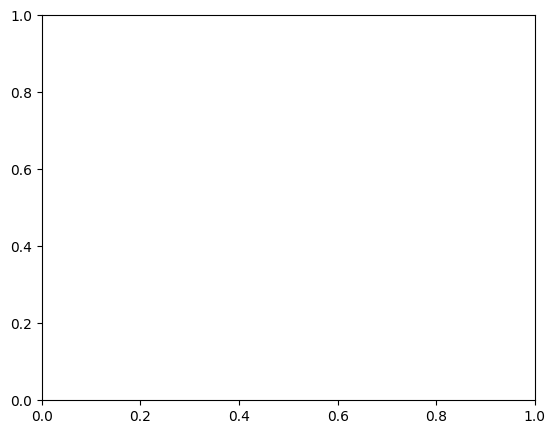

In [22]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(
    epochs_range,
    history_model1d.history["accuracy"],
    label="Training Accuracy,1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model1d.history["val_accuracy"],
    label="Validation Accuracy, 1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["accuracy"],
    label="Training Accuracy, 2D model with trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["val_accuracy"],
    label="Validation Accuracy, 2D model with trainable STFT",
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(
    epochs_range,
    history_model1d.history["loss"],
    label="Training Loss,1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model1d.history["val_loss"],
    label="Validation Loss, 1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["loss"],
    label="Training Loss, 2D model with trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["val_loss"],
    label="Validation Loss, 2D model with trainable STFT",
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Model Evaluation

In [ ]:
_, test_acc = model1d.evaluate(test_x, test_y)
print(f"1D model wit non-trainable STFT -> Test Accuracy: {test_acc * 100:.2f}%")

In [ ]:
_, test_acc = model2d.evaluate(test_x, test_y)
print(f"2D model with trainable STFT -> Test Accuracy: {test_acc * 100:.2f}%")

## References
- https://keras.io/examples/